In [127]:
!pip install -U scikit-learn

In [128]:
# ignore warnings

import warnings
warnings.filterwarnings('ignore')

In [129]:
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-fundamentals-and-applications-2024-08/final_proj_data.csv
/kaggle/input/ml-fundamentals-and-applications-2024-08/final_proj_test.csv
/kaggle/input/ml-fundamentals-and-applications-2024-08/final_proj_sample_submission.csv


In [130]:
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import shap
from lightgbm import LGBMClassifier
from sklearn.preprocessing import PowerTransformer, TargetEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import make_scorer, balanced_accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn import set_config

In [131]:
shap.initjs()
set_config(transform_output="pandas")
random_state = 42

In [132]:
train = pd.read_csv('/kaggle/input/ml-fundamentals-and-applications-2024-08/final_proj_data.csv')
test = pd.read_csv('/kaggle/input/ml-fundamentals-and-applications-2024-08/final_proj_test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 231 entries, Var1 to y
dtypes: float64(191), int64(2), object(38)
memory usage: 17.6+ MB


In [133]:
train.describe()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var184,Var185,Var186,Var187,Var188,Var189,Var190,Var209,Var230,y
count,133.000000,266.0,266.000000,280.000000,2.410000e+02,8980.000000,8995.000000,0.0,133.000000,2.410000e+02,...,266.000000,0.0,133.000000,133.000000,266.000000,4206.000000,43.000000,0.0,0.0,10000.00000
mean,14.977444,0.0,341.052632,0.096429,2.338101e+05,1340.916258,6.860700,NaN,61.383459,3.672943e+05,...,6.180451,NaN,2.977444,20.601504,159.107368,272.455064,25725.112326,NaN,NaN,0.13050
std,66.456008,0.0,2810.606975,0.928243,5.532305e+05,2380.516758,6.300994,NaN,266.124849,8.234215e+05,...,12.177204,NaN,10.329764,93.736247,115.766972,86.752531,37487.484852,NaN,NaN,0.33687
min,0.000000,0.0,0.000000,0.000000,0.000000e+00,0.000000,0.000000,NaN,0.000000,0.000000e+00,...,0.000000,NaN,0.000000,0.000000,0.000000,6.000000,0.000000,NaN,NaN,0.00000
25%,0.000000,0.0,0.000000,0.000000,0.000000e+00,523.250000,0.000000,NaN,2.000000,0.000000e+00,...,0.000000,NaN,0.000000,0.000000,18.840000,204.000000,1312.875000,NaN,NaN,0.00000
50%,0.000000,0.0,0.000000,0.000000,0.000000e+00,861.000000,7.000000,NaN,18.000000,0.000000e+00,...,0.000000,NaN,0.000000,4.000000,194.670000,270.000000,10853.820000,NaN,NaN,0.00000
75%,16.000000,0.0,0.000000,0.000000,1.172350e+05,1428.000000,7.000000,NaN,40.000000,2.439360e+05,...,7.000000,NaN,0.000000,12.000000,247.080000,330.000000,37491.525000,NaN,NaN,0.00000
max,680.000000,0.0,42588.000000,9.000000,3.024000e+06,76195.000000,35.000000,NaN,2300.000000,6.394806e+06,...,64.000000,NaN,102.000000,878.000000,452.760000,642.000000,191167.200000,NaN,NaN,1.00000


Дані містять багато пропусків та нульових значень. В частини числових змінних дужк зміщені вліво розподіли із наявністю аутлаєрів. По-перше, видалено всі ознаки, які містять більше 30% пропущених значень.  

In [134]:
columns_with_nan = train.columns[train.isna().mean().gt(0.3)]
columns_with_nan                            

Index(['Var1', 'Var2', 'Var3', 'Var4', 'Var5', 'Var8', 'Var9', 'Var10',
       'Var11', 'Var12',
       ...
       'Var200', 'Var201', 'Var209', 'Var213', 'Var214', 'Var215', 'Var224',
       'Var225', 'Var229', 'Var230'],
      dtype='object', length=163)

In [135]:
train = train.drop(columns_with_nan, axis = 1)
test = test.drop(columns_with_nan, axis = 1)
train.shape

(10000, 68)

In [136]:
train.isna().mean().sort_values(ascending=False)

Var126    0.278
Var24     0.136
Var109    0.136
Var149    0.136
Var6      0.102
          ...  
Var207    0.000
Var198    0.000
Var204    0.000
Var113    0.000
y         0.000
Length: 68, dtype: float64

In [137]:
test.isna().mean().sort_values(ascending=False)

Var126    0.2848
Var149    0.1472
Var24     0.1472
Var109    0.1472
Var74     0.1088
           ...  
Var193    0.0000
Var113    0.0000
Var57     0.0000
Var73     0.0000
Var228    0.0000
Length: 67, dtype: float64

In [138]:
train.duplicated().sum()

0

In [139]:
train.skew(numeric_only=True)

Var6      12.262550
Var7       1.352816
Var13     10.168912
Var21     16.478526
Var22     16.536072
Var24      8.071358
Var25     13.496533
Var28      4.731732
Var35      6.444871
Var38      1.107181
Var44     17.816443
Var57     -0.014228
Var65      2.085809
Var73      0.841976
Var74     18.050388
Var76      2.802532
Var78      5.808068
Var81      2.921827
Var83     26.155132
Var85     13.177699
Var109    21.595046
Var112    12.883710
Var113    -1.074561
Var119    17.604608
Var123    25.332244
Var125    25.090343
Var126     0.635994
Var132     4.273061
Var133     1.290760
Var134     2.615101
Var140     5.462813
Var143    12.838947
Var144     1.213175
Var149    11.391872
Var153    -0.282752
Var160    14.986289
Var163     4.729003
Var173    20.245126
Var181     5.418719
y          2.194166
dtype: float64

In [140]:
target = train['y']
train.drop('y', axis = 1, inplace = True)
target.isnull().sum()

0

Видалено ознаки, які мають більше 50% нульових значень.

In [141]:
threshold = 0.5
zero_fraction = (train == 0).mean()
columns_to_drop = zero_fraction[zero_fraction > threshold].index
train = train.drop(columns=columns_to_drop)
test = test.drop(columns=columns_to_drop)

print("Removed features:", columns_to_drop)

Removed features: Index(['Var35', 'Var44', 'Var78', 'Var132', 'Var143', 'Var173', 'Var181'], dtype='object')


Проаналізовано кількість унікальних значень в числових та категоріальних ознаках. Дискретні ознаки із кількістю унікальних значень, менше 100, будуть оброблятися як категоріальні. В цих ознаках відразу заповнено пропуски модою та змінено тип на string.

In [142]:
train.select_dtypes(include=np.number).nunique()

Var6       859
Var7         6
Var13     1575
Var21      411
Var22      411
Var24       56
Var25      159
Var28     1747
Var38     6660
Var57     8602
Var65       11
Var73      127
Var74      227
Var76     6437
Var81     8826
Var83      108
Var85       88
Var109     122
Var112     137
Var113    9787
Var119     816
Var123     159
Var125    4197
Var126      51
Var133    7855
Var134    7080
Var140    1430
Var144      10
Var149    4223
Var153    8242
Var160     220
Var163    5146
dtype: int64

In [143]:
# Select descrete features and set them as categorical, fill nan with mode
threshold = 100
discrete_columns = [col for col in train.select_dtypes(include=np.number).columns if train[col].nunique() < threshold]
for col in discrete_columns:
    train[col] = train[col].fillna(train[col].mode()[0])
    test[col] = test[col].fillna(test[col].mode()[0])
    train[col] = train[col].astype(int).astype(str)
    test[col] = test[col].astype(int).astype(str)

In [144]:
train.select_dtypes(include='object').nunique()

Var7         6
Var24       56
Var65       11
Var85       88
Var126      51
Var144      10
Var192     297
Var193      40
Var195      18
Var196       3
Var197     185
Var198    2100
Var199    1850
Var202    3802
Var203       4
Var204     100
Var205       3
Var206      21
Var207      12
Var208       2
Var210       6
Var211       2
Var212      65
Var216     977
Var217    5529
Var218       2
Var219      17
Var220    2100
Var221       7
Var222    2100
Var223       4
Var226      23
Var227       7
Var228      29
dtype: int64

Категоріальні змінні із високою кардинальністю (більше 300 унікальних значень) було видалено. Збережено змінну Var216 із початковою кількістю 977 унікальних значень шляхом об'єдняння в більш великі категорії, взявши лише 3 перших символи. Таким чином, кількість унікальних значень для ознаки Var216 зменшилась до 31.

In [145]:
train['Var216'] = train['Var216'].str[:3]
test['Var216'] = test['Var216'].str[:3]

In [146]:
# Drop high cardinality features
train_cat = train.select_dtypes(include='object')
threshold = 300
columns_to_drop = [col for col in train_cat.columns if train_cat[col].nunique() > threshold]

train = train.drop(columns = columns_to_drop)
test = test.drop(columns = columns_to_drop)

Нарешті, видалено ознаки із сильно зміщеним розподілом (skew > 5). Була спроба зменшити зміщення видаливши викиди за цими ознаками, взявши лише значення до 98-ого перцентилю, але це не покращило метрики. Після очищення, в датасеті залищилось 39 ознак.

In [147]:
skewness =  train.select_dtypes(include='number').skew()
high_skew_features = skewness[abs(skewness) > 5].index
train = train.drop(columns = high_skew_features)
test = test.drop(columns = high_skew_features)

train.shape

(10000, 39)

Пропущені значення заповнені за допомогою SimpleImputer, попередньо розділивши дані на окремі датасети із числовими та категоріальними ознаками. Були експерименти із різними видами імпутерів - KNNImputer, IterativeImputer, що не покращило метрику. Категоріальні ознаки закодовано за допомогою TargetEncoder, після чого датасети знов об'єднано в один і застосовано PowerTransformer для масштабування і вирівнювання розподілів.

In [148]:
train_num = train.select_dtypes(include=np.number)
train_cat = train.select_dtypes(include='object')

test_num = test.select_dtypes(include=np.number)
test_cat = test.select_dtypes(include='object')

In [149]:
num_imputer = SimpleImputer()
train_num = num_imputer.fit_transform(train_num)
test_num = num_imputer.transform(test_num)

In [150]:
cat_imputer = SimpleImputer(
    strategy='most_frequent').set_output(transform='pandas')
train_cat = cat_imputer.fit_transform(train_cat)
test_cat = cat_imputer.transform(test_cat)

In [151]:
encoder = TargetEncoder(random_state=42).set_output(transform='pandas')

train_cat = encoder.fit_transform(train_cat, target)
test_cat = encoder.transform(test_cat)

In [152]:
train = pd.concat([train_num, train_cat], axis=1)
test = pd.concat([test_num, test_cat], axis=1)

In [153]:
power_transform = PowerTransformer().set_output(transform='pandas')

train = power_transform.fit_transform(train)
test = power_transform.transform(test)

In [154]:
target.value_counts(normalize=True)

y
0    0.8695
1    0.1305
Name: proportion, dtype: float64

Дані не збалансовані за цільовою ознакою, тому застосовано Smote. Проекспериментовано із різними техніками (SmoteENN, SmoteSVM), які покращували метрики на крос-валідації, але не покращували загальний public score.

In [155]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(train, target)

Візуалізовано важливість ознак за допомогою shap. Найбільш важливою ознакою є Var126, яка мала майже 30% пропущених значень у початкових даних. Ознаки із низькими значеннями важливості не видалено, окільки подальше зменшення кількості ознак не покращувало метрики.

[LightGBM] [Info] Number of positive: 8695, number of negative: 8695
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007717 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9933
[LightGBM] [Info] Number of data points in the train set: 17390, number of used features: 39
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


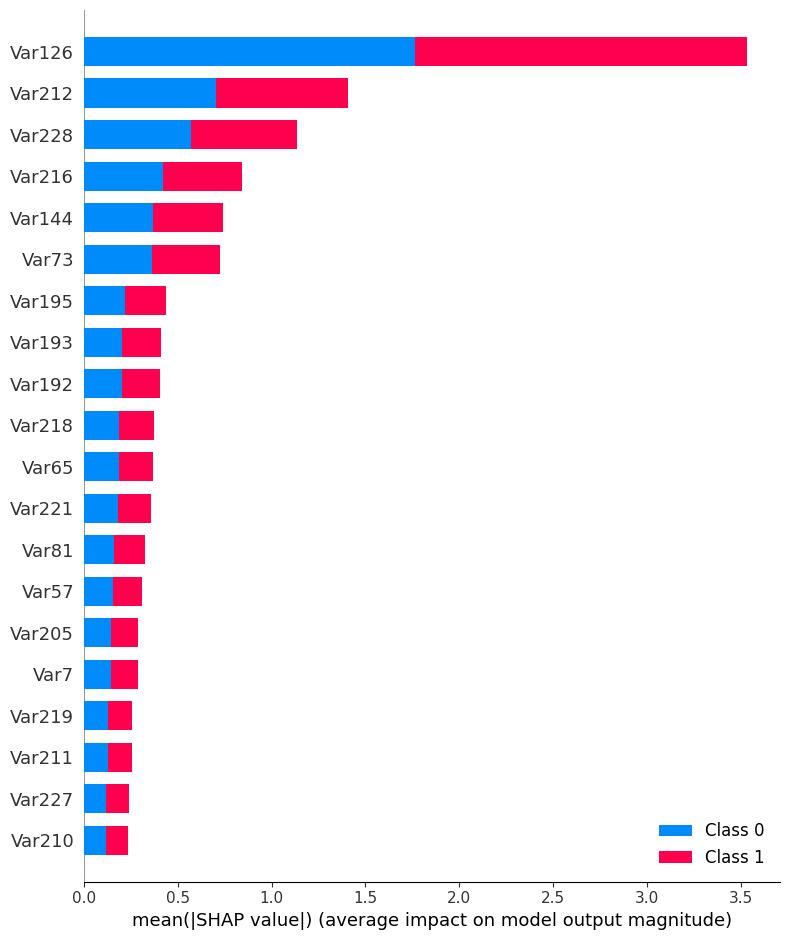

In [156]:
base_model = LGBMClassifier()
base_model.fit(X_res, y_res)
explainer = shap.Explainer(base_model)
shap_values = explainer.shap_values(X_res)
shap.summary_plot(shap_values, X_res)

In [157]:
shap_values_class1 = shap_values[1]
shap_importance = np.mean(np.abs(shap_values_class1), axis=0)
shap_importance_df = pd.DataFrame({
    'feature': X_res.columns,
    'importance': shap_importance
}).sort_values(by='importance', ascending=False)
shap_importance_df

,feature,importance
15,Var126,1.766224
30,Var212,0.703938
38,Var228,0.569095
31,Var216,0.421557
16,Var144,0.369453
3,Var73,0.361930
19,Var195,0.219564
18,Var193,0.204449
17,Var192,0.203599
32,Var218,0.185762


Підбір гіперпараметрів для моделі LightGBM здійснено за допомогою бібліотеки Optuna. Модель була обрана в результаті експериментів із різними моделями/ансамблями моделей за найкращим результатом public score.

In [158]:
# # Search for best parameters for Lgbm
# def objective(trial):
#     params = {
#         'n_estimators': trial.suggest_int('n_estimators', 50, 600),
#         'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
#         'num_leaves': trial.suggest_int('num_leaves', 20, 150),
#         'max_depth': trial.suggest_int('max_depth', -10, 50),
#         'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
#         'min_child_weight': trial.suggest_loguniform('min_child_weight', 1e-3, 10.0),
#         'subsample': trial.suggest_float('subsample', 0.5, 1.0),
#         'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
#         'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, 10.0),
#     }
    
#     model = LGBMClassifier(**params, force_col_wise=True, random_state=random_state)
    

#     cv =KFold(n_splits=5, shuffle=True, random_state=random_state)
    
#     scorer = make_scorer(balanced_accuracy_score)
    
#     scores = cross_val_score(model, X_res, y_res, cv=cv, scoring=scorer)

#     return scores.mean()

# # Creating study
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=200, timeout=3600)  

# # Best parameters
# print("Best hyperparameters: ", study.best_params)
# print("Best balanced accuracy score: ", study.best_value)

In [159]:
best_params_lgbm = {'n_estimators': 312, 
                    'learning_rate': 0.16076356163457786,
                    'num_leaves': 94, 
                    'max_depth': 39, 
                    'min_child_samples': 78, 
                    'min_child_weight': 0.0033382326846117423, 
                    'subsample': 0.5214820053421904, 
                    'colsample_bytree': 0.7145948312664728, 
                    'reg_alpha': 0.0003301840924882873, 
                    'reg_lambda': 4.394710596158503e-08, 
                    'scale_pos_weight': 1.2626834640188729}

lgbm = LGBMClassifier(**best_params_lgbm, min_gain_to_split=0.0, force_col_wise=True, verbosity=-1, random_state=random_state)
lgbm.fit(X_res, y_res)

LGBMClassifier(colsample_bytree=0.7145948312664728, force_col_wise=True,
               learning_rate=0.16076356163457786, max_depth=39,
               min_child_samples=78, min_child_weight=0.0033382326846117423,
               min_gain_to_split=0.0, n_estimators=312, num_leaves=94,
               random_state=42, reg_alpha=0.0003301840924882873,
               reg_lambda=4.394710596158503e-08,
               scale_pos_weight=1.2626834640188729,
               subsample=0.5214820053421904, verbosity=-1)

In [160]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(
    estimator=lgbm,
    X=X_res,
    y=y_res,
    scoring='balanced_accuracy',
    cv=kf,
    verbose=1)

print(cv_results)

[0.95936817 0.95799889 0.96382505 0.96233147 0.96523405]


In [162]:
preds_lgbm = lgbm.predict(test)
output = pd.DataFrame({'index':test.index,
                       'y': preds_lgbm})

output.to_csv('submission.csv', index = False)